# Exploring the datasets

This notebook contains the code of our project.

In [readme.ipynb](readme.ipynb) you will find a full description of the project along with the results. 

If you are viewing this file on github, some of the maps will not be rendered, check the blogpost at this [link](https://themien.github.io/docgs_veneto.html).

## 1. Importing libraries <a id='section1'></a>

In [1]:
import branca as bc
import folium
import itertools
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import seaborn as sns
sns.set()
import shapefile as shp

from geopy.geocoders import Nominatim
from IPython.display import Image, IFrame
from IPython.core.display import HTML 
from sklearn.cluster import KMeans

## 2. Loading the datasets <a id='section2'></a>

### A. Getting the relevant geojson data <a id='section21'></a>

In [2]:
docgs_shp_path = r'data/shapefile_data/Zone_DOCG.shp'

docgs_sf = shp.Reader(docgs_shp_path)

We then create a function to read the shapefile into a pandas <code>DataFrame</code>.

In [3]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

Now we can use the function get the data and remove the unnecessary columns.

In [4]:
docgs_df = read_shapefile(docgs_sf)

docgs_df = docgs_df[['denominazi', 'codice', 'zona', 'coords']]
docgs_df.columns = ['appellation', 'code', 'zone', 'coords']
docgs_df.head()

,appellation,code,zone,coords
0,RECIOTO SOAVE CLASSICO,A021,A,"[(11.252029507865142, 45.41758433331832), (11...."
1,RECIOTO SOAVE,A021,X,"[(11.207064614961942, 45.4507371295929), (11.2..."
2,BARDOLINO SUPERIORE CLASSICO,A025,A,"[(10.794778650134427, 45.518760038125784), (10..."
3,BARDOLINO SUPERIORE,A025,X,"[(10.843049258063267, 45.43160165449561), (10...."
4,SOAVE SUPERIORE CLASSICO,A026,A,"[(11.252029507865142, 45.41758433331832), (11...."


In the following function we will be creating our geojson file.

In [5]:
def shape2json(reader, outfile='veneto_docg.json', country='Italy'):
    
    fields = reader.fields[1:]
    field_names = [field[0] for field in fields]
    buffer = []
    for sr in reader.shapeRecords():
        atr = dict(zip(field_names, sr.record))
        geom = sr.shape.__geo_interface__
        buffer.append(dict(type='Feature', \
        geometry=geom, properties=atr)) 

    with open(outfile, 'w') as geojson:
        geojson.write(json.dumps({'type': 'FeatureCollection',
                             'features': buffer}, indent=2) + '\n')

shape2json(docgs_sf, outfile=r'data/veneto_docg.json', country='Italy')

We can plot the areas on a map to check out where they are situated.

In [6]:
venezia = 'Venezia'

geolocator = Nominatim(user_agent="veneto_finder")
location = geolocator.geocode(venezia, country_codes='it')
latitude = location.latitude
longitude = location.longitude
venezia_ll = '{lat},{lon}'.format(lat=latitude, lon=longitude)
    
def plot_docgs_map(location):
    docgs_map = folium.Map(location=location, zoom_start=8, tiles='OpenStreetMap')

    docgs_geo = r'data/veneto_docg.json'

    tooltip = folium.features.GeoJsonTooltip(
        fields=['denominazi'],
        aliases=['Appellation'],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    )

    folium.GeoJson(
        docgs_geo,
        name='geojson',
        tooltip=tooltip,
        style_function=lambda feature: {
            'fillColor': '#ffff00',
            'color': 'black',
            'weight': 2,
            'dashArray': '5, 5'}).add_to(docgs_map)
    
    return docgs_map


docgs_map = plot_docgs_map(venezia_ll.split(','))
# docgs_map.save('maps/docgs.html')

In [7]:
IFrame('maps/docgs.html', width=1000, height=450)

### B. Municipalities geojson

In [8]:
comunes_shp_path = r'data/shapefile_data/Comuni_Veneto_1.shp'

comunes_sf = shp.Reader(comunes_shp_path, encoding='windows-1252')
comunes_df = read_shapefile(comunes_sf)

comunes_df.head()

,Comune,Prov,CODISTAT,NOMCOM,PROVINCIA,AREA,PERIMETER,ID1,coords
0,29033,29,29033,Occhiobello,RO,3.251909e+07,28900.15864,527,"[(11.574961743249316, 44.95070722627497), (11...."
1,29025,29,29025,Gaiba,RO,1.206460e+07,18468.00608,526,"[(11.479809311494138, 44.97789519756071), (11...."
2,29009,29,29009,Canaro,RO,3.266567e+07,33974.60289,525,"[(11.661722276937734, 44.97455175786645), (11...."
3,29021,29,29021,Ficarolo,RO,1.796072e+07,21152.56640,524,"[(11.440782497382445, 44.98232147591316), (11...."
4,29045,29,29045,Stienta,RO,2.408899e+07,24452.03201,523,"[(11.559372185120054, 44.98162314511416), (11...."


In [9]:
shape2json(comunes_sf, outfile=r'data/comunes.json', country='Italy')

In [14]:
def plot_comunes_map(location):
    comunes_map = folium.Map(location=location, zoom_start=8, tiles='OpenStreetMap')

    comunes_geo = r'data/comunes.json'

    tooltip = folium.features.GeoJsonTooltip(
        fields=['NOMCOM'],
        aliases=['Comune name'],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    )

    folium.GeoJson(
        comunes_geo,
        name='geojson',
        tooltip=tooltip,
    ).add_to(comunes_map)
    
    return comunes_map

comunes_map = plot_comunes_map(venezia_ll.split(','))
# comunes_map.save('maps/comunes.html')

In [16]:
IFrame('maps/comunes.html', width=1000, height=500)

### C. Downloading touristic cities data <a id='section22'></a>

In order to get the relevant cities we will again be using a dataset from DatiOpen, it can be found at this [link](http://www.datiopen.it/it/opendata/Regione_Veneto_Turismo_arrivi_per_comune).

Our purpose here will be to select major touristic cities in the DOCG areas. 

In [17]:
tourism_df = pd.read_csv('data/tourism.csv', sep=';')
tourism_df.drop('Unnamed: 4', axis=1, inplace=True)

tourism_df.columns=['year', 'comune', 'province', 'n_tourists']
tourism_df['n_tourists'] = tourism_df['n_tourists'].str.replace(',', '')
tourism_df['n_tourists'] = tourism_df['n_tourists'].astype('float')
tourism_df.tail()

,year,comune,province,n_tourists
5572,2013,Taglio di Po,ROVIGO,4819.0
5573,2013,Trecenta,ROVIGO,482.0
5574,2013,Villadose,ROVIGO,584.0
5575,2013,Villamarzana,ROVIGO,NaN
5576,2013,Porto Viro,ROVIGO,2566.0


In [18]:
by_comune = tourism_df.groupby('comune')['n_tourists'].sum()
touristic_cities = list(by_comune.sort_values(ascending=False)[:41].index)
touristic_cities[:5]

['Venezia',
 'Iesolo',
 'San Michele al Tagliamento',
 'Cavallino-Treporti',
 'Verona']

We then remove the cities that are not in our area of interest.

In [19]:
to_remove = ['ALTRO', 'Malcesine', "Cortina d'Ampezzo", 'Livinallongo del Col di Lana',
             'Auronzo di Cadore', 'Rocca Pietore', 'Falcade', 'Rosolina', 'Rovigo']
for city in to_remove:
    touristic_cities.remove(city)

# changing Venezia to Venice as the italian name is not found by Nominatim
touristic_cities[0] = 'Venice'

Now we can use <code>Nominatim</code> from <code>geopy</code> to find the latitudes and longitudes.

In [24]:
city_lat, city_lon = [], []

for name in touristic_cities:
    geolocator = Nominatim(user_agent="veneto_finder")
    location = geolocator.geocode(name, country_codes='it')
    city_lat.append(location.latitude)
    city_lon.append(location.longitude)
    
cities_df = pd.DataFrame(zip(touristic_cities, city_lat, city_lon), columns=['city', 'latitude', 'longitude'])
cities_df = cities_df.sort_values('city')
cities_df.head()

,city,latitude,longitude
8,Abano Terme,45.360314,11.789783
29,Asiago,45.875377,11.510700
9,Bardolino,45.547559,10.724215
26,Bassano del Grappa,45.766911,11.734347
24,Brenzone,45.707599,10.765873


We can visualize the location of this touristic centers on the DOCGs map.

In [27]:
for i in range(len(cities_df)):
    folium.Marker(location=[cities_df.iloc[i]['latitude'], cities_df.iloc[i]['longitude']],
                 popup=cities_df.iloc[i]['city'], 
                 tooltip=cities_df.iloc[i]['city']
    ).add_to(docgs_map)

docgs_map.save('maps/selected_cities.html')

In [28]:
IFrame('maps/selected_cities.html', width=1000, height=450)

### Foursquare API

We will now use the foursquare API to get information about venues in these cities.

# TO REMOVE

In [29]:
CLIENT_ID = '0IUOF1N0TRY5FIIM0MJVLBQ5OTP501CP4YRSQVNV5RGP34XI' 
CLIENT_SECRET = '4MKROMXBGT52O5XMJIRTVNH0RECT4ETCYG0X0LFJULTD5O2O' 

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(client_id=CLIENT_ID,
                      client_secret=CLIENT_SECRET,
                      v='20180323',
                      ll='{lat},{lng}'.format(lat=lat, lng=lng),
                      radius=radius,
                      limit=100)
        results = requests.get(url, params=params).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['city', 
                  'city_lat', 
                  'city_lon', 
                  'venue', 
                  'venue_lat', 
                  'venue_lon', 
                  'category']
    
    return(nearby_venues)

In [32]:
venues_df = getNearbyVenues(names=cities_df['city'],
                            latitudes=cities_df['latitude'],
                            longitudes=cities_df['longitude'])
venues_df.head()

,city,city_lat,city_lon,venue,venue_lat,venue_lon,category
0,Abano Terme,45.360314,11.789783,L'ombra Che Conta,45.361623,11.790219,Trattoria/Osteria
1,Abano Terme,45.360314,11.789783,Abano Grand Hotel,45.354321,11.785206,Hotel
2,Abano Terme,45.360314,11.789783,Panoramic Hotel Plaza,45.354413,11.783820,Hotel
3,Abano Terme,45.360314,11.789783,Grand Hotel Trieste & Victoria,45.352713,11.781310,Hotel
4,Abano Terme,45.360314,11.789783,Parco Urbano Termale,45.351798,11.783535,Park


In [33]:
HTML('Our query returned a total of {tot} venues in the areas of interest. '
     'We can see the total number of venues found for each category.'.format(tot=venues_df.shape[0]))

In [34]:
venues_df.groupby('category')['venue'].count().to_frame().head()

,venue
category,
Accessories Store,2
Agriturismo,3
American Restaurant,7
Argentinian Restaurant,1
Art Gallery,3


We can visualize the top 5 venue categories for each location.

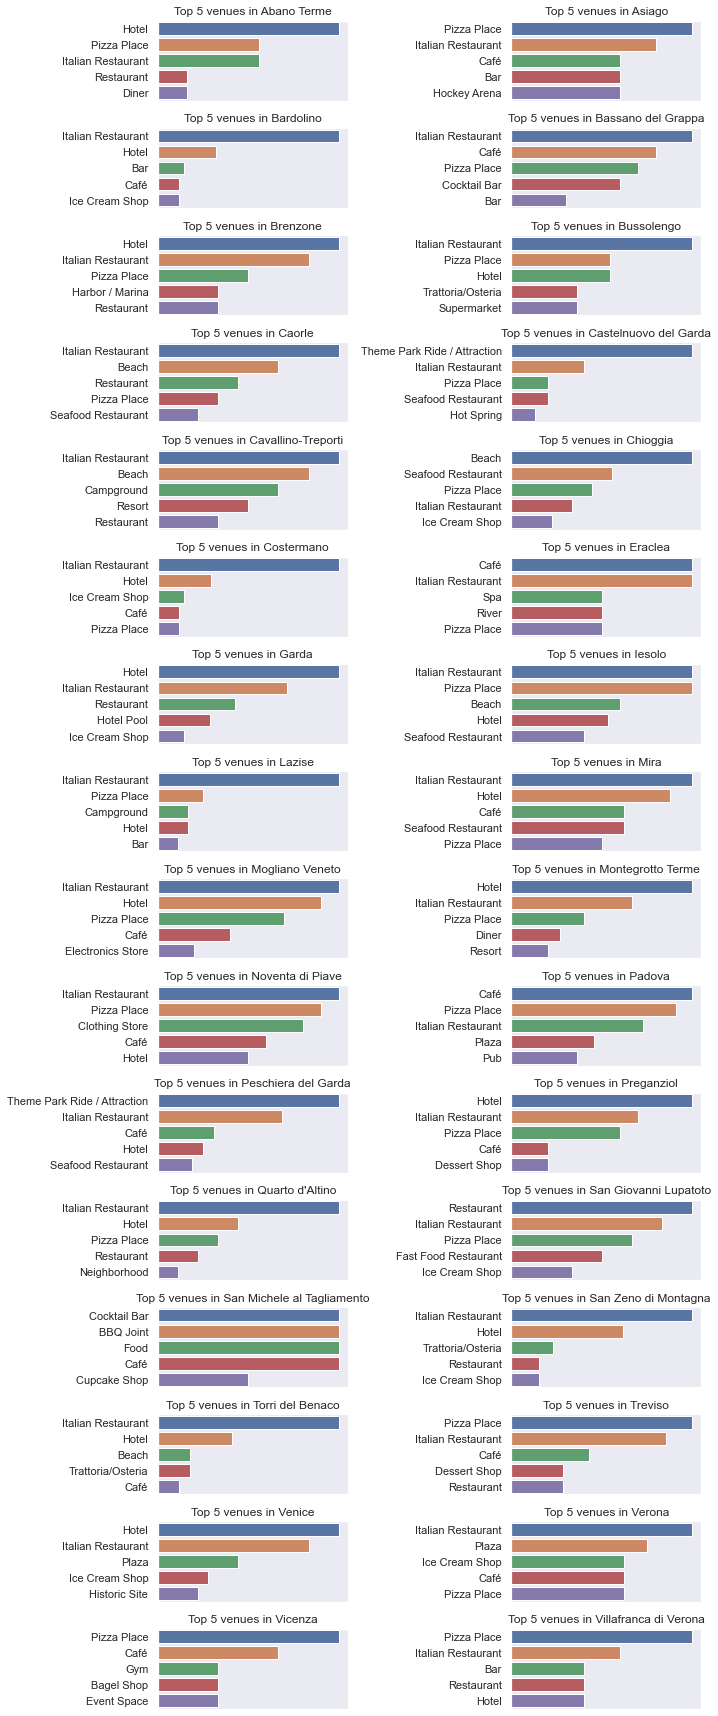

In [35]:
fig, ax = plt.subplots(16, 2, figsize=(10, 24))

row_idx = -1
col_idx = -1
for i, city in enumerate(venues_df['city'].unique()):
    
    if i%2==0:
        row_idx += 1
        col_idx = 0
        
    df = venues_df[venues_df['city']==city]['category'].value_counts()[:5]
    sns.barplot(df.values, df.index, palette='deep', ax=ax[row_idx, col_idx])
    ax[row_idx, col_idx].set_title('Top 5 venues in {}'.format(city))
    ax[row_idx, col_idx].set_xticks(())    
    col_idx += 1
    
fig.tight_layout()

fig.savefig('img/top_5_per_location')

Great, we can now use this data to start clustering and segmenting the different cities.

## Clustering

In [154]:
venues_onehot = pd.get_dummies(venues_df[['category']], prefix="", prefix_sep="")

venues_onehot['city'] = venues_df['city'] 

# move city column to first position
col_to_order = ['city']
new_columns = col_to_order + (venues_onehot.columns.drop(col_to_order).tolist())
venues_onehot = venues_onehot[new_columns]

venues_onehot.head()

,city,Accessories Store,Agriturismo,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Cafeteria,Café,Campground,Canal,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Coworking Space,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Football Stadium,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kids Store,Lake,Lighthouse,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Nudist Beach,Opera House,Outdoors & Recreation,Outlet Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Piadineria,Pizza Place,Plaza,Pool,Pub,Public Art,Racetrack,Record Shop,Resort,Rest Area,Restaurant,River,Road,Rock Club,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Snack Place,Soccer Field,Spa,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,University,Used Bookstore,Vacation Rental,Vegetarian / Vegan Restaurant,Veneto Restaurant,Video Game Store,Water Park,Waterfront,Wine Bar,Wine Shop,Winery,Women's Store,Zoo
0,Abano Terme,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Abano Terme,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Abano Terme,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Abano Terme,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Abano Terme,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [190]:
venues_grouped = venues_onehot.groupby('city').mean().reset_index()
venues_grouped.head()

,city,Accessories Store,Agriturismo,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Cafeteria,Café,Campground,Canal,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Coworking Space,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Football Stadium,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kids Store,Lake,Lighthouse,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Nudist Beach,Opera House,Outdoors & Recreation,Outlet Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Piadineria,Pizza Place,Plaza,Pool,Pub,Public Art,Racetrack,Record Shop,Resort,Rest Area,Restaurant,River,Road,Rock Club,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Snack Place,Soccer Field,Spa,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,University,Used Bookstore,Vacation Rental,Vegetarian / Vegan Restaurant,Veneto Restaurant,Video Game Store,Water Park,Waterfront,Wine Bar,Wine Shop,Winery,Women's Store,Zoo
0,Abano Terme,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.00000,0.020000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.01,0.00000,0.00000,0.00,0.0,0.00,0.0,0.030000,0.00,0.0,0.00,0.000000,0.02,0.0,0.01,0.0,0.00,0.020000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.01000,0.04000,0.0,0.0,0.01,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00,0.01000,0.0,0.0,0.00000,0.00,0.00,0.00,0.000000,0.0,0.00,0.00000,0.00,0.000000,0.01,0.25000,0.0,0.01,0.03,0.00,0.140000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.00,0.00,0.00,0.0,0.01000,0.0,0.0,0.0,0.0,0.0,0.01000,0.0,0.0,0.0,0.00,0.0,0.140000,0.000000,0.01,0.02,0.0,0.0,0.00,0.01,0.0,0.040000,0.00,0.0,0.01,0.00,0.00,0.01,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.00000,0.00,0.0,0.01,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.02,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.010000,0.0,0.01,0.0,0.0
1,Asiago,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.02381,0.071429,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.02381,0.02381,0.00,0.0,0.00,0.0,0.071429,0.00,0.0,0.00,0.047619,0.00,0.0,0.00,0.0,0.00,0.023810,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.02381,0.02381,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.02381,0.0,0.00,0.02381,0.0,0.0,0.02381,0.00,0.00,0.00,0.000000,0.0,0.00,0.02381,0.00,0.071429,0.00,0.02381,0.0,0.00,0.00,0.00,0.095238,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.02381,0.0,0.0,0.0,0.0,0.0,0.02381,0.0,0.0,0.0,0.00,0.0,0.119048,0.047619,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.047619,0.00,0.0,0

In [191]:
venues_grouped.shape

(32, 184)

In [192]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [193]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['city'] = venues_grouped['city']

for ind in np.arange(venues_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abano Terme,Hotel,Pizza Place,Italian Restaurant,Diner,Restaurant,Ice Cream Shop,Café,Bar,Cocktail Bar,Pub
1,Asiago,Pizza Place,Italian Restaurant,Hockey Arena,Café,Bar,Plaza,Wine Bar,Cheese Shop,Restaurant,Trail
2,Bardolino,Italian Restaurant,Hotel,Bar,Café,Ice Cream Shop,Beach,Restaurant,Campground,Food,Cocktail Bar
3,Bassano del Grappa,Italian Restaurant,Café,Pizza Place,Cocktail Bar,Fast Food Restaurant,Pub,Bar,Ice Cream Shop,Museum,Coffee Shop
4,Brenzone,Hotel,Italian Restaurant,Pizza Place,Harbor / Marina,Restaurant,Café,Cocktail Bar,Beach,Seafood Restaurant,Dive Bar
5,Bussolengo,Italian Restaurant,Hotel,Pizza Place,Supermarket,Trattoria/Osteria,Restaurant,Electronics Store,Café,Japanese Restaurant,Steakhouse
6,Caorle,Italian Restaurant,Beach,Restaurant,Pizza Place,Seafood Restaurant,Ice Cream Shop,Cocktail Bar,Hotel,Dessert Shop,Pub
7,Castelnuovo del Garda,Theme Park Ride / Attraction,Italian Restaurant,Pizza Place,Seafood Restaurant,Hotel,Dessert Shop,Campground,Café,Hot Spring,Rest Area
8,Cavallino-Treporti,Italian Restaurant,Beach,Campground,Resort,Restaurant,Seafood Restaurant,Pizza Place,Snack Place,Bar,Cocktail Bar
9,Chioggia,Beach,Seafood Restaurant,Pizza Place,Italian Restaurant,Café,Ice Cream Shop,Park,Resort,Scenic Lookout,Donut Shop


In [194]:
cities = venues_grouped['city'].values
venues_grouped = venues_grouped.drop('city', 1)

ks = range(1, 12)
inertias = []

for k in ks:
    k_means = KMeans(init="k-means++", n_clusters=k, n_init=12)
    k_means.fit(venues_grouped)
    inertias.append(k_means.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ks, inertias)
ax.axvline(5, color='r', linestyle=(0, (5,10)))
ax.set_title('Sum of squared distances of samples to their closest cluster center for different k values')
ax.set_xlabel('k')
ax.set_xticks([k for k in ks])
ax.set_ylabel('Inertia')
ax.set_yticks(())
fig.savefig('img/k-means_inertia')

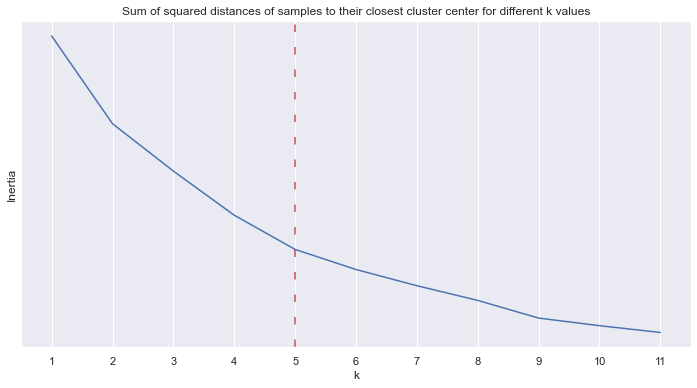

In [195]:
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped)

In [196]:
kmeans.labels_

array([2, 0, 3, 0, 2, 0, 4, 1, 4, 4, 3, 0, 2, 0, 3, 0, 0, 2, 0, 0, 1, 2,
       3, 0, 0, 3, 3, 0, 2, 0, 0, 0])

In [235]:
cities_clustered =  cities_df.copy()
cities_clustered['cluster'] = kmeans.labels_
cities_clustered.loc[cities_clustered['city']=='Venice', 'city'] = 'VENEZIA'
cities_clustered[cities_clustered['cluster']==4]['city'].values

array(['Caorle', 'Cavallino-Treporti', 'Chioggia'], dtype=object)

---

In [198]:
def add_categorical_legend(folium_map, title, colors, labels):
    """
    Given a Folium map, add to it a categorical legend with the given title, colors, and corresponding labels.
    The given colors and labels will be listed in the legend from top to bottom.
    Return the resulting map.
    
    Based on `this example <http://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd>`_.
    """
    if len(colors) != len(labels):
        raise ValueError("colors and labels must have the same length.")

    color_by_label = dict(zip(labels, colors))

    # Make legend HTML
    template = f"""
    {{% macro html(this, kwargs) %}}

    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
    </head>
    <body>
    <div id='maplegend' class='maplegend'>
      <div class='legend-title'>{title}</div>
      <div class='legend-scale'>
        <ul class='legend-labels'>
    """

    for label, color in color_by_label.items():
        template += f"<li><span style='background:{color}'></span>{label}</li>"

    template += """
        </ul>
      </div>
    </div>

    </body>
    </html>

    <style type='text/css'>
      .maplegend {
        position: absolute;
        z-index:9999;
        background-color: rgba(255, 255, 255, 1);
        border-radius: 5px;
        border: 2px solid #bbb;
        padding: 10px;
        font-size:12px;
        right: 10px;
        bottom: 20px;
      }
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 0px solid #ccc;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    {% endmacro %}
    """

    macro = bc.element.MacroElement()
    macro._template = bc.element.Template(template)
    folium_map.get_root().add_child(macro)

    return folium_map

In [199]:
with open('data/comunes.json', 'r', encoding='windows-1252') as geo_data_file:
    data = json.load(geo_data_file)
    
    features = []
    for k,v in itertools.groupby([x for x in data['features'] if x['properties']['NOMCOM'] in cities_clustered['city'].unique()]):
        features.append(k)
    
    data['features'] = features
          
    with open('data/comunes_filtered.json', 'w') as data_file:
        data = json.dump(data, data_file)

In [200]:
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e']
categories = sorted(cities_clustered['cluster'].unique() + 1)
categories

[1, 2, 3, 4, 5]

In [201]:
def apply_color(feature):
    city = feature['properties']['NOMCOM']
    color = None
    try:
        cluster = cities_clustered[cities_clustered['city']==city]['cluster'].values[0]
        if cluster == 0: color = colors[0]
        if cluster == 1: color = colors[1]
        if cluster == 2: color = colors[2]
        if cluster == 3: color = colors[3]
        if cluster == 4: color = colors[4]
        if cluster == 5: color = colors[5]
    except:
        color='black'
    return {
        "fillColor": color,
        "color": 'black',
        "weight": 1,
        "fillOpacity": 1,
           }

comunes_map = folium.Map(location=venezia_ll.split(','), zoom_start=8, tiles='OpenStreetMap')
folium.TileLayer(tiles="cartodbpositron", attr="", name="basemap").add_to(comunes_map)
  
# folium.GeoJson(
#         data='data/veneto_docg.json',
#         name='geojson',
#         style_function=lambda feature: {
#             'fillColor': '#ffff00',
#             'color': 'black',
#             'weight': 0.5,
#             'dashArray': '5, 5'}).add_to(comunes_map)

folium.GeoJson(
    data='data/comunes_filtered.json',
    name='comunes',
    style_function=lambda feature: apply_color(feature),
    highlight_function=lambda x: {"weight": 3},
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NOMCOM'],
        aliases=['Comune'],
        sticky=True,
        opacity=0.9,
        direction="bottom",
    ),
).add_to(comunes_map)

# folium.LayerControl(collapsed=True).add_to(comunes_map)

comunes_map = add_categorical_legend(comunes_map, 'Cluster', colors=colors, labels=categories)

comunes_map.save('maps/cities_clustered.html')

In [202]:
IFrame('maps/cities_clustered.html', width=1000, height=550)

In [203]:
cities_venues_sorted['cluster'] = kmeans.labels_ + 1
cities_venues_sorted.head()

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
0,Abano Terme,Hotel,Pizza Place,Italian Restaurant,Diner,Restaurant,Ice Cream Shop,Café,Bar,Cocktail Bar,Pub,3
1,Asiago,Pizza Place,Italian Restaurant,Hockey Arena,Café,Bar,Plaza,Wine Bar,Cheese Shop,Restaurant,Trail,1
2,Bardolino,Italian Restaurant,Hotel,Bar,Café,Ice Cream Shop,Beach,Restaurant,Campground,Food,Cocktail Bar,4
3,Bassano del Grappa,Italian Restaurant,Café,Pizza Place,Cocktail Bar,Fast Food Restaurant,Pub,Bar,Ice Cream Shop,Museum,Coffee Shop,1
4,Brenzone,Hotel,Italian Restaurant,Pizza Place,Harbor / Marina,Restaurant,Café,Cocktail Bar,Beach,Seafood Restaurant,Dive Bar,3


In [204]:
for k in range(kclusters):
    display(HTML('<h3>Cluster {k}:</h3>'.format(k=k+1)))
    display(cities_venues_sorted.loc[cities_venues_sorted['cluster'] == k+1])

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
1,Asiago,Pizza Place,Italian Restaurant,Hockey Arena,Café,Bar,Plaza,Wine Bar,Cheese Shop,Restaurant,Trail,1
3,Bassano del Grappa,Italian Restaurant,Café,Pizza Place,Cocktail Bar,Fast Food Restaurant,Pub,Bar,Ice Cream Shop,Museum,Coffee Shop,1
5,Bussolengo,Italian Restaurant,Hotel,Pizza Place,Supermarket,Trattoria/Osteria,Restaurant,Electronics Store,Café,Japanese Restaurant,Steakhouse,1
11,Eraclea,Café,Italian Restaurant,Pub,BBQ Joint,Supermarket,Outdoors & Recreation,Spa,River,Pizza Place,Cupcake Shop,1
13,Iesolo,Pizza Place,Italian Restaurant,Beach,Hotel,Seafood Restaurant,Cocktail Bar,Plaza,Café,Pub,Ice Cream Shop,1
15,Mira,Italian Restaurant,Hotel,Seafood Restaurant,Café,Pizza Place,Pub,Gastropub,Diner,Supermarket,Food & Drink Shop,1
16,Mogliano Veneto,Italian Restaurant,Hotel,Pizza Place,Café,Pub,Tennis Court,Food,Electronics Store,Train Station,Furniture / Home Store,1
18,Noventa di Piave,Italian Restaurant,Pizza Place,Clothing Store,Café,Hotel,Boutique,Hotel Bar,Wine Bar,Sporting Goods Shop,Outlet Store,1
19,Padova,Café,Pizza Place,Italian Restaurant,Plaza,Pub,Ice Cream Shop,Gastropub,Bar,Restaurant,Japanese Restaurant,1
23,San Giovanni Lupatoto,Restaurant,Italian Restaurant,Pizza Place,Fast Food Restaurant,Food & Drink Shop,American Restaurant,Hotel,Supermarket,Ice Cream Shop,Japanese Restaurant,1


,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
7,Castelnuovo del Garda,Theme Park Ride / Attraction,Italian Restaurant,Pizza Place,Seafood Restaurant,Hotel,Dessert Shop,Campground,Café,Hot Spring,Rest Area,2
20,Peschiera del Garda,Theme Park Ride / Attraction,Italian Restaurant,Café,Hotel,Seafood Restaurant,Theme Park,Campground,Trattoria/Osteria,Restaurant,Beach,2


,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
0,Abano Terme,Hotel,Pizza Place,Italian Restaurant,Diner,Restaurant,Ice Cream Shop,Café,Bar,Cocktail Bar,Pub,3
4,Brenzone,Hotel,Italian Restaurant,Pizza Place,Harbor / Marina,Restaurant,Café,Cocktail Bar,Beach,Seafood Restaurant,Dive Bar,3
12,Garda,Hotel,Italian Restaurant,Restaurant,Hotel Pool,City,Trattoria/Osteria,Harbor / Marina,Resort,Diner,Campground,3
17,Montegrotto Terme,Hotel,Italian Restaurant,Pizza Place,Diner,Resort,Nightclub,Trattoria/Osteria,Outdoors & Recreation,Chinese Restaurant,Dessert Shop,3
21,Preganziol,Hotel,Italian Restaurant,Pizza Place,Dessert Shop,Café,Pub,Cupcake Shop,Cocktail Bar,Breakfast Spot,Seafood Restaurant,3
28,Venice,Hotel,Italian Restaurant,Plaza,Ice Cream Shop,Historic Site,Church,Wine Bar,Museum,Bakery,Scenic Lookout,3


,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
2,Bardolino,Italian Restaurant,Hotel,Bar,Café,Ice Cream Shop,Beach,Restaurant,Campground,Food,Cocktail Bar,4
10,Costermano,Italian Restaurant,Hotel,Ice Cream Shop,Pizza Place,Café,Restaurant,Trail,Beach,Cocktail Bar,Trattoria/Osteria,4
14,Lazise,Italian Restaurant,Pizza Place,Campground,Hotel,Bar,Restaurant,Ice Cream Shop,Theme Park,Museum,Café,4
22,Quarto d'Altino,Italian Restaurant,Hotel,Pizza Place,Restaurant,Pub,Bowling Alley,Cheese Shop,Bistro,Department Store,Cafeteria,4
25,San Zeno di Montagna,Italian Restaurant,Hotel,Trattoria/Osteria,Café,Pizza Place,Restaurant,Ice Cream Shop,Campground,Beach,Diner,4
26,Torri del Benaco,Italian Restaurant,Hotel,Trattoria/Osteria,Beach,Café,Restaurant,Beach Bar,Thai Restaurant,Theme Park,Scenic Lookout,4


,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,cluster
6,Caorle,Italian Restaurant,Beach,Restaurant,Pizza Place,Seafood Restaurant,Ice Cream Shop,Cocktail Bar,Hotel,Dessert Shop,Pub,5
8,Cavallino-Treporti,Italian Restaurant,Beach,Campground,Resort,Restaurant,Seafood Restaurant,Pizza Place,Snack Place,Bar,Cocktail Bar,5
9,Chioggia,Beach,Seafood Restaurant,Pizza Place,Italian Restaurant,Café,Ice Cream Shop,Park,Resort,Scenic Lookout,Donut Shop,5


In [205]:
venues_grouped['cluster'] = kmeans.labels_ + 1
# venues_grouped['city'] = cities_venues_sorted['city']
venues_grouped

,Accessories Store,Agriturismo,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Cafeteria,Café,Campground,Canal,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Coworking Space,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Football Stadium,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hot Spring,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kids Store,Lake,Lighthouse,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Nudist Beach,Opera House,Outdoors & Recreation,Outlet Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Piadineria,Pizza Place,Plaza,Pool,Pub,Public Art,Racetrack,Record Shop,Resort,Rest Area,Restaurant,River,Road,Rock Club,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Snack Place,Soccer Field,Spa,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Trattoria/Osteria,University,Used Bookstore,Vacation Rental,Vegetarian / Vegan Restaurant,Veneto Restaurant,Video Game Store,Water Park,Waterfront,Wine Bar,Wine Shop,Winery,Women's Store,Zoo,cluster
0,0.000000,0.000000,0.010000,0.00,0.00,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.030000,0.000000,0.00,0.00000,0.000000,0.020000,0.000000,0.010,0.000000,0.000000,0.020000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.010000,0.040000,0.000000,0.00,0.010000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.010000,0.010000,0.00,0.010000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.010000,0.250000,0.000000,0.010000,0.030000,0.00,0.140000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.01,0.000000,0.000000,0.00000,0.00,0.000000,0.010000,0.000000,0.000,0.00,0.000000,0.000000,0.010000,0.00,0.00,0.000000,0.00,0.000000,0.140000,0.000000,0.010000,0.020000,0.000000,0.00,0.00,0.010000,0.000000,0.040000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.00000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.010000,0.00,0.010000,0.000000,0.000000,3
1,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.023810,0.071429,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [231]:
test = venues_grouped
test = test[test>0.09].groupby('cluster').mean()
test = test.transpose()

for cluster in range(1,6):
    print(cluster)
    t = test[[cluster]]
    display(t.dropna())

1


cluster,1
BBQ Joint,0.104278
Café,0.140828
Clothing Store,0.103896
Cocktail Bar,0.117647
Food,0.117647
Hotel,0.119096
Italian Restaurant,0.133974
Outdoors & Recreation,0.090909
Pizza Place,0.138631
Pub,0.090909


2


cluster,2
Italian Restaurant,0.149802
Theme Park Ride / Attraction,0.283234


3


cluster,3
Hotel,0.227050
Italian Restaurant,0.162131
Pizza Place,0.121418
Restaurant,0.100000


4


cluster,4
Hotel,0.138006
Italian Restaurant,0.338304
Pizza Place,0.111111


5


cluster,5
Beach,0.187273
Campground,0.153846
Italian Restaurant,0.227885
Pizza Place,0.097561
Resort,0.115385
Restaurant,0.100000
Seafood Restaurant,0.121951
